In [1]:
%load_ext autoreload
%autoreload 2
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz/bin'

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("talk")
#%load_ext line_profiler
import numpy as np
import pandas as pd
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (11,8)
from sklearn.ensemble import RandomForestRegressor
from merf.utils import MERFDataGenerator
from merf.merf import MERF
from merf.viz import plot_merf_training_stats
import wbgapi as wb
import gpboost as gpb
import sklearn.datasets as datasets
import time
from statsmodels.datasets import grunfeld
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split
import shap
import graphviz 
import lightgbm

In [2]:
pwd

'C:\\Users\\Akshay'

In [3]:
def simulate_response_variable(lp, rand_eff, likelihood):
    """Function that simulates response variable for various likelihoods"""
    n = len(rand_eff)
    if likelihood == "gaussian":
        xi = 0.25 * np.random.normal(size=n) # error term
        y = lp + rand_eff + xi
    elif likelihood == "bernoulli_probit":
        probs = stats.norm.cdf(lp + rand_eff)
        y = np.random.uniform(size=n) < probs
        y = y.astype(np.float64)
    elif likelihood == "bernoulli_logit":
        probs = 1 / (1 + np.exp(-(lp + rand_eff)))
        y = np.random.uniform(size=n) < probs
        y = y.astype(np.float64)
    elif likelihood == "poisson":
        mu = np.exp(lp + rand_eff)
        y = stats.poisson.ppf(np.random.uniform(size=n), mu=mu)
    elif likelihood == "gamma":
        mu = np.exp(lp + rand_eff)
        y = mu * stats.gamma.ppf(np.random.uniform(size=n), a=1)
    return y

In [4]:
country_name_list = ["Albania", "Argentina", "Armenia", "Australia", "Austria", "Azerbaijan", "Belarus", "Belgium", "Bosnia and Herzegovina", "Bulgaria", "Canada", "Chile", "China", "Croatia", 
                     "Cyprus",  "Czech Republic", "Denmark", "Estonia", "Finland",     "France", "Georgia", "Germany", "Greece", "Hungary", "Iceland", "India",  "Ireland",     
                     "Israel",  "Italy", "Japan", "Kazakhstan", "Korea, Rep.",   "Latvia",   "Lithuania", "Luxembourg", "Mexico",   "Moldova", "Montenegro",
                     "Netherlands", "North Macedonia", "Norway", "Poland", "Portugal", "Romania", "Russian Federation",   "Serbia",  "Singapore",   "Slovak Republic", 
                     "Slovenia", "South Africa", "Spain", "Sweden",  "Switzerland", "Turkey",  "Turkiye", "Ukraine", "United Kingdom", "United States"]
country_list = list(wb.economy.coder(country_name_list).values())
country_set = set(country_list)

year_list = range(1994, 2022)



wb_measures_list = ['EN.ATM.CO2E.KT', 'NY.GDP.MKTP.PP.KD','SP.POP.TOTL', 'GB.XPD.RSDV.GD.ZS',
 'EG.FEC.RNEW.ZS', 'SP.URB.TOTL.IN.ZS', 'NV.MNF.TECH.ZS.UN', 'NE.TRD.GNFS.ZS']



raw_dat  = wb.data.DataFrame(wb_measures_list, country_set, year_list)
WBdf=raw_dat.reset_index()


In [5]:
WBdf.set_index(['economy','series']).isnull().sum(level=0)
dummy=WBdf.drop(['economy','series','YR2020','YR2021'],axis=1)



Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().


In [6]:
dummy[['economy','series']]=WBdf[['economy','series']]
dummy=dummy.pivot(index='economy',columns='series')
dummy=dummy.stack(0)
dummy=dummy.reset_index() 
dummy.rename(columns = {'level_1':'Year'}, inplace = True)


In [7]:
dummy.isnull().sum()
dummy = dummy.dropna()
t=pd.crosstab(index=dummy['economy'], columns='count')

e_out=t[t['count']<=24*.5]
for a in e_out.index:
    print(a)
    dummy=dummy.drop(dummy[dummy['economy'] ==a].index)

ALB
CHE
MNE


In [8]:
rmv_ls=list(e_out.index)
rmv_ls
for i in rmv_ls:
    country_list.remove(i)

In [9]:
len(country_list)

55

In [10]:
MainData=dummy
MainData['logCO2percap']=np.log(dummy['EN.ATM.CO2E.KT'].div(dummy['SP.POP.TOTL']))

MainData=MainData.drop(['EN.ATM.CO2E.KT','SP.POP.TOTL'],axis=1)

for i in MainData.columns[2:8]:
    MainData[i]=np.log(MainData[i])
MainData.head()

MainData['Year'] = MainData['Year'].str[2:]
MainData['Year'] = MainData['Year'].apply(pd.to_numeric)
MainData.head()
MainData = MainData.rename({'EG.FEC.RNEW.ZS': 'Renewable_energy_consumption', 'GB.XPD.RSDV.GD.ZS': 'Research and development expenditure', 'NE.TRD.GNFS.ZS' : 'Trade', 'NV.MNF.TECH.ZS.UN' : 'Medium and high-tech manufacturing value added', 'NY.GDP.MKTP.PP.KD' : 'GDP PPP', 'SP.URB.TOTL.IN.ZS' : 'Urban population'}, axis='columns')
 

In [11]:
MainData

series,economy,Year,Renewable_energy_consumption,Research and development expenditure,Trade,Medium and high-tech manufacturing value added,GDP PPP,Urban population,logCO2percap
28,ARG,1996,2.321785,-0.873495,3.068354,3.352131,27.181800,4.481487,-5.661599
29,ARG,1997,2.397811,-0.868477,3.150005,3.433446,27.259789,4.483725,-5.644479
30,ARG,1998,2.428602,-0.888408,3.150598,3.415867,27.297568,4.485925,-5.605170
31,ARG,1999,2.332743,-0.791047,3.062584,3.336023,27.263127,4.488097,-5.602530
32,ARG,2000,2.287471,-0.823620,3.118943,3.353258,27.255206,4.490231,-5.630330
...,...,...,...,...,...,...,...,...,...
1477,ZAF,2015,2.330200,-0.312699,4.038245,3.195731,27.377378,4.171738,-4.870447
1478,ZAF,2016,2.354228,-0.287789,4.022871,3.195731,27.384002,4.179620,-4.884390
1479,ZAF,2017,2.346602,-0.271061,3.980353,3.195731,27.395515,4.187379,-4.874138
1480,ZAF,2018,2.321407,-0.376047,3.998340,3.195731,27.410281,4.195019,-4.890764


split

In [12]:
import random
random.seed(10)
print(random.random())

0.5714025946899135


In [13]:
DF_test=[]
s_list=[]
for i in country_list:
    contry_tmp=MainData.loc[MainData['economy'] == i]
    s=len(contry_tmp)
    s_list.append(s)
    #list_tmp=list(range(s))
    
    #list_tmp.pop()
    test_row_tmp=pd.DataFrame(contry_tmp.iloc[s-1])
    test_row_tmp=test_row_tmp.T
    DF_test.append(test_row_tmp)

DF_test=pd.concat(DF_test)

In [14]:
drop_row_train=list(DF_test.index.values)
drop_row_train;
DF_train =MainData.drop(labels=drop_row_train, axis=0)

In [15]:
drop_row_test=list(DF_train.index.values)
drop_row_test;
DF_test =MainData.drop(labels=drop_row_test, axis=0)

In [16]:
Z_train = np.ones((len(DF_train), 1))
Z_test= np.ones((len(DF_test), 1))
clusters_test = DF_test[['economy',"Year"]]
clusters_train = DF_train[['economy',"Year"]]

In [17]:
X_train=DF_train.drop(['economy','Year',"logCO2percap"],  axis=1)
X_test=DF_test.drop(['economy','Year',"logCO2percap"],  axis=1)
Y_train = DF_train['logCO2percap']
Y_test = DF_test['logCO2percap']

In [18]:
gp_model = gpb.GPModel(group_data=clusters_train)

data_train = gpb.Dataset(X_train, Y_train)

params = { 'objective': 'regression_l2', 'learning_rate': 1,
    'max_depth': 6, 'min_data_in_leaf': 1, 'verbose': 0 }

bst = gpb.train(params=params, train_set=data_train, gp_model=gp_model, num_boost_round=1800)
gp_model.summary() 


[GPBoost] [Warning] Find whitespaces in feature_names, replace with underlines
Covariance parameters (random effects):
            Param.
Error_term  0.3732
economy     0.0634
Year        0.0000


3.510484350094355


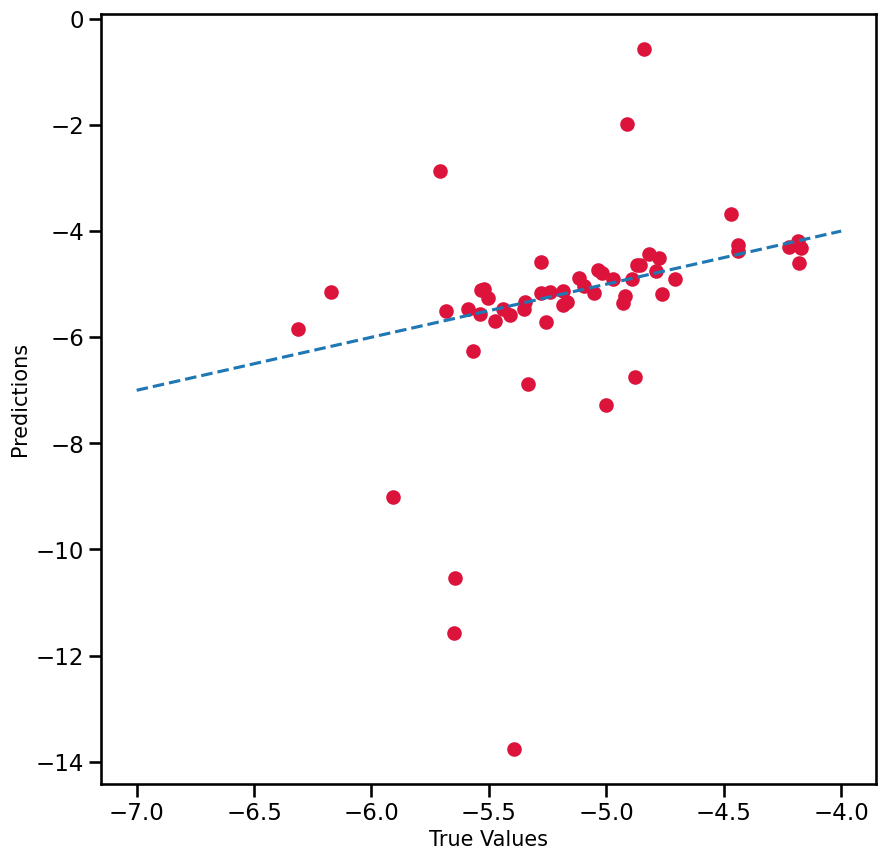

In [19]:
pred = bst.predict(data=X_test, group_data_pred= clusters_test,
                   predict_var=True, pred_latent=False)



pred = pred["response_mean"]

print(mse(Y_test, pred))

plt.figure(figsize=(10,10))
ax_x=range(-7,-3)
plt.plot(ax_x,ax_x,"--")
plt.scatter(Y_test, pred, c='crimson')




plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)

plt.show()


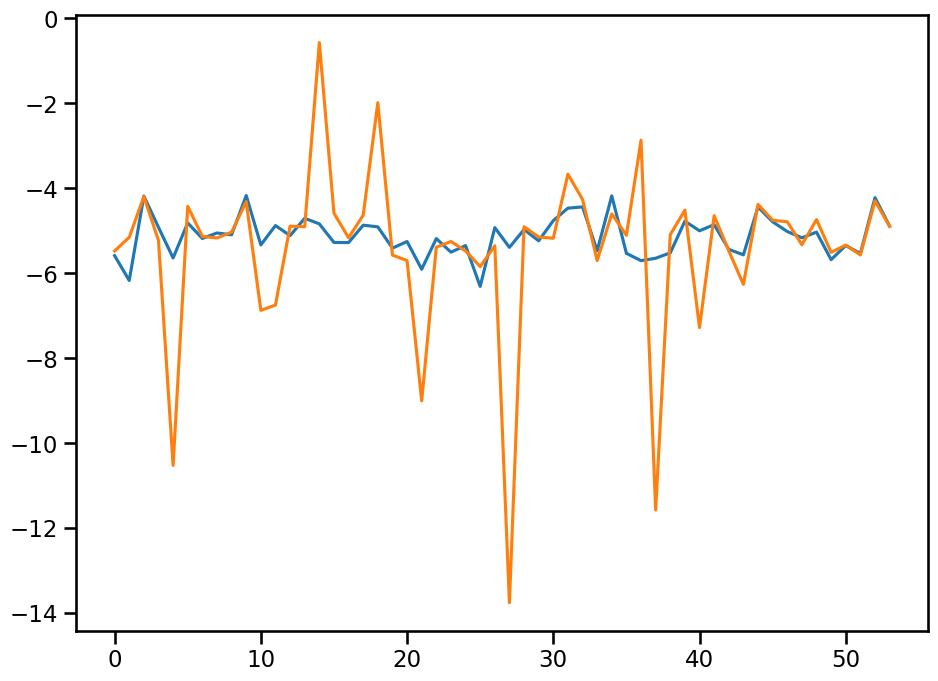

In [20]:
x_ax=range(len(Y_test))
plt.plot(x_ax,Y_test,label="original")
plt.plot(x_ax,pred,label="predicted")
plt.show()

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

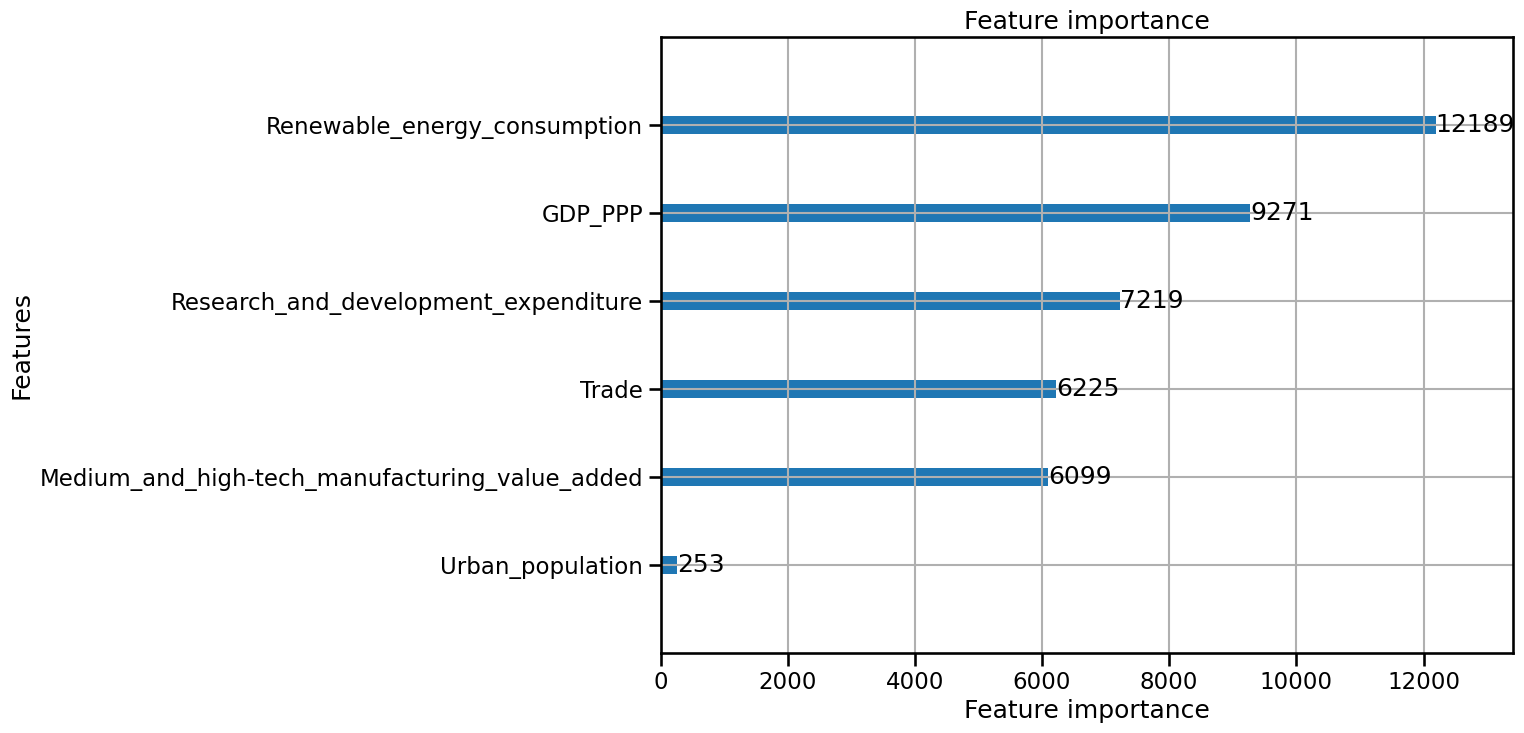

In [21]:
gpb.plot_importance(bst)


In [22]:


gpb.plot_tree(bst, figsize = (50,50), dpi = 600)



<AxesSubplot:>

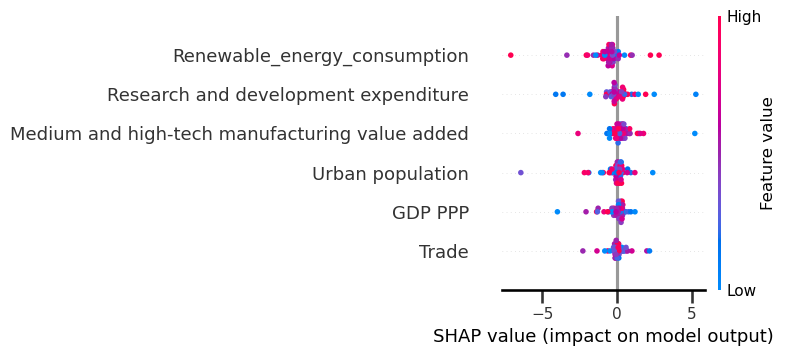

In [23]:
shap_values = shap.TreeExplainer(bst).shap_values(X_test)
shap.summary_plot(shap_values, X_test)

In [26]:
likelihood = "gaussian"
param_grid = {'learning_rate': [ 0.1, 0.0001], 'min_data_in_leaf': [4,5,6,8],
                    'max_depth': [3,4,5]}
gp_model = gpb.GPModel(group_data=clusters_train, likelihood= likelihood)
data_train = gpb.Dataset(X_train, Y_train)
opt_params = gpb.grid_search_tune_parameters(param_grid=param_grid,
                                             params=params,
                                             num_try_random=None,
                                             nfold=5,
                                             gp_model=gp_model,
                                             use_gp_model_for_validation=True,
                                             train_set=data_train,
                                             verbose_eval=0,
                                             num_boost_round=1000, 
                                             early_stopping_rounds=10,
                                             seed=1000)
print("Best parameters: " + str(opt_params['best_params']))
print("Best number of iterations: " + str(opt_params['best_iter']))
print("Best score: " + str(opt_params['best_score']))

[GPBoost] [Warning] Find whitespaces in feature_names, replace with underlines
[GPBoost] [Warning] Find whitespaces in feature_names, replace with underlines
[GPBoost] [Warning] Find whitespaces in feature_names, replace with underlines
[GPBoost] [Warning] Find whitespaces in feature_names, replace with underlines
[GPBoost] [Warning] Find whitespaces in feature_names, replace with underlines
[GPBoost] [Warning] Find whitespaces in feature_names, replace with underlines
[GPBoost] [Warning] Find whitespaces in feature_names, replace with underlines
[GPBoost] [Warning] Find whitespaces in feature_names, replace with underlines
[GPBoost] [Warning] Find whitespaces in feature_names, replace with underlines
[GPBoost] [Warning] Find whitespaces in feature_names, replace with underlines
[GPBoost] [Warning] Find whitespaces in feature_names, replace with underlines
[GPBoost] [Warning] Find whitespaces in feature_names, replace with underlines
[GPBoost] [Warning] Find whitespaces in feature_name

In [28]:
likelihood = "gaussian"
gp_model = gpb.GPModel(group_data=clusters_train, likelihood= likelihood)

data_train = gpb.Dataset(X_train, Y_train)

params_new = { 'learning_rate': 0.0001,
    'max_depth': 4, 'min_data_in_leaf':8}

bst_new = gpb.train(params=params_new, train_set=data_train, gp_model=gp_model, num_boost_round=907)
gp_model.summary() 

[GPBoost] [Warning] Find whitespaces in feature_names, replace with underlines
[GPBoost] [Info] Total Bins 1530
[GPBoost] [Info] Number of data points in the train set: 1159, number of used features: 6
[GPBoost] [Info] [GPBoost with gaussian likelihood]: initscore=-5.046849
[GPBoost] [Info] Start training from score -5.046849
Covariance parameters (random effects):
            Param.
Error_term  0.0003
economy     0.2806
Year        0.0007


In [ ]:
pred_new = bst_new.predict(data=X_test, group_data_pred= clusters_test,
                   predict_var=True, pred_latent=False)



pred_new = pred_new["response_mean"]

mse(Y_test, pred_new, squared=False)


In [ ]:
x_ax=range(len(Y_test))
plt.plot(x_ax,Y_test,label="original")
plt.plot(x_ax,pred_new,label="predicted")
plt.show()

plt.figure(figsize=(10,10))
ax_x=range(-7,-3)
plt.plot(ax_x,ax_x,"--")
plt.scatter(Y_test, pred_new, c='crimson')




plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)

plt.show()


In [ ]:
gpb.plot_tree(bst_new, figsize = (50,50), dpi = 600)

In [ ]:
gpb.plot_importance(bst_new)


In [ ]:
shap_values = shap.TreeExplainer(bst_new).shap_values(X_test)
shap.summary_plot(shap_values, X_test)

In [33]:
gp_model_ar1 = gpb.GPModel(group_data=clusters_train['economy'], gp_coords=clusters_train['Year'], cov_function="exponential")
data_train = gpb.Dataset(X_train, Y_train)

# Train GPBoost model (takes a few seconds)
bst_new_1 = gpb.train(params=params_new,
                train_set=data_train,
                gp_model=gp_model_ar1,
                num_boost_round=907)

gp_model_ar1.summary()
cov_pars = gp_model_ar1.get_cov_pars()
phi_hat = np.exp(-1/cov_pars['GP_range'])
sigma2_hat = cov_pars['GP_var'] * (1. - phi_hat ** 2)
print("Estimated innovation variance and AR(1) coefficient of year effect:")
print([sigma2_hat ,phi_hat])

[GPBoost] [Warning] Find whitespaces in feature_names, replace with underlines
[GPBoost] [Info] Total Bins 1530
[GPBoost] [Info] Number of data points in the train set: 1159, number of used features: 6
[GPBoost] [Info] [GPBoost with gaussian likelihood]: initscore=-5.046849
[GPBoost] [Info] Start training from score -5.046849
Covariance parameters (random effects):
            Param.
Error_term  0.0003
economy     0.2794
GP_var      0.0011
GP_range    5.5781
Estimated innovation variance and AR(1) coefficient of year effect:
[Param.    0.000338
dtype: float64, Param.    0.835877
Name: GP_range, dtype: float64]


In [34]:
pred_new_1 = bst_new_1.predict(data=X_test, group_data_pred= clusters_test['economy'], gp_coords_pred =  clusters_test['Year'],
                   predict_var=True, pred_latent=False)



pred_new_1 = pred_new_1["response_mean"]

mse(Y_test, pred_new_1, squared=False)

0.10954411067288979

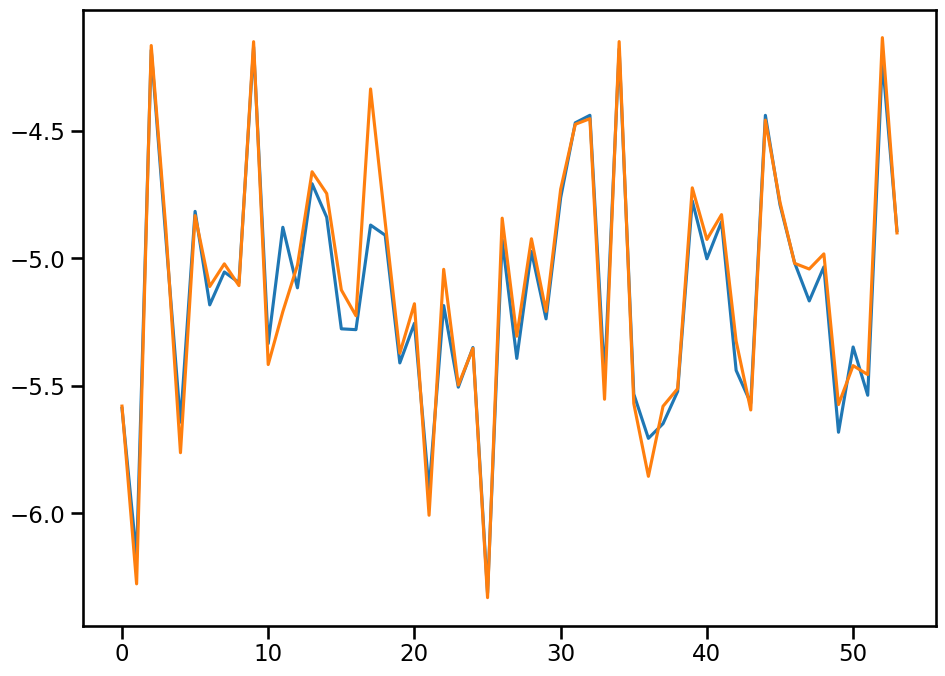

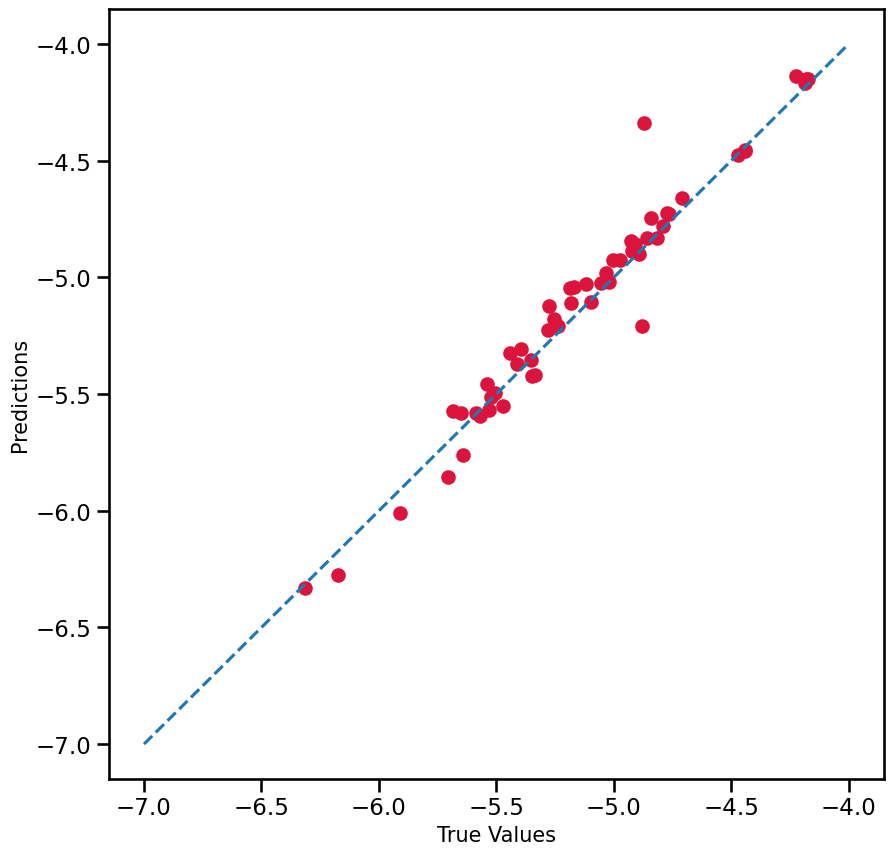

In [35]:
x_ax=range(len(Y_test))
plt.plot(x_ax,Y_test,label="original")
plt.plot(x_ax,pred_new_1,label="predicted")
plt.show()

plt.figure(figsize=(10,10))
ax_x=range(-7,-3)
plt.plot(ax_x,ax_x,"--")
plt.scatter(Y_test, pred_new_1, c='crimson')




plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)

plt.show()

In [38]:
gp_model_ar1 = gpb.GPModel(group_data=clusters_train['economy'], gp_coords=clusters_train['Year'], 
                           cluster_ids=clusters_train['economy'])
# Need to use the more robust option gradient_descent instead of fisher_scoring in this example
gp_model_ar1.set_optim_params(params={"optimizer_cov": "gradient_descent"})
data_train = gpb.Dataset(X_train, Y_train)
# Train GPBoost model (takes a few seconds)
bst_ar = gpb.train(params=params_new,
                train_set=data_train,
                gp_model=gp_model_ar1,
                num_boost_round=907)
# Estimated random effects model (variances of random effects and range parameters)
gp_model_ar1.summary()
cov_pars = gp_model_ar1.get_cov_pars()
phi_hat = np.exp(-1/cov_pars['GP_range'])
sigma2_hat = cov_pars['GP_var'] * (1. - phi_hat ** 2)
print("Estimated innovation variance and AR(1) coefficient of year effect:")
print([sigma2_hat ,phi_hat])

[GPBoost] [Warning] Find whitespaces in feature_names, replace with underlines
[GPBoost] [Info] Total Bins 1530
[GPBoost] [Info] Number of data points in the train set: 1159, number of used features: 6
[GPBoost] [Info] [GPBoost with gaussian likelihood]: initscore=-5.046849
[GPBoost] [Info] Start training from score -5.046849
Covariance parameters (random effects):
               Param.
Error_term     0.0000
economy        0.0000
GP_var         0.2925
GP_range    3074.0139
Estimated innovation variance and AR(1) coefficient of year effect:
[Param.    0.00019
dtype: float64, Param.    0.999675
Name: GP_range, dtype: float64]


In [39]:
pred_new_ar = bst_ar.predict(data=X_test, group_data_pred= clusters_test['economy'], gp_coords_pred =  clusters_test['Year'], cluster_ids_pred =clusters_test['economy'],
                   predict_var=True, pred_latent=False)



pred_new_ar = pred_new_ar["response_mean"]

mse(Y_test, pred_new_ar, squared=False)

0.08410329281523828

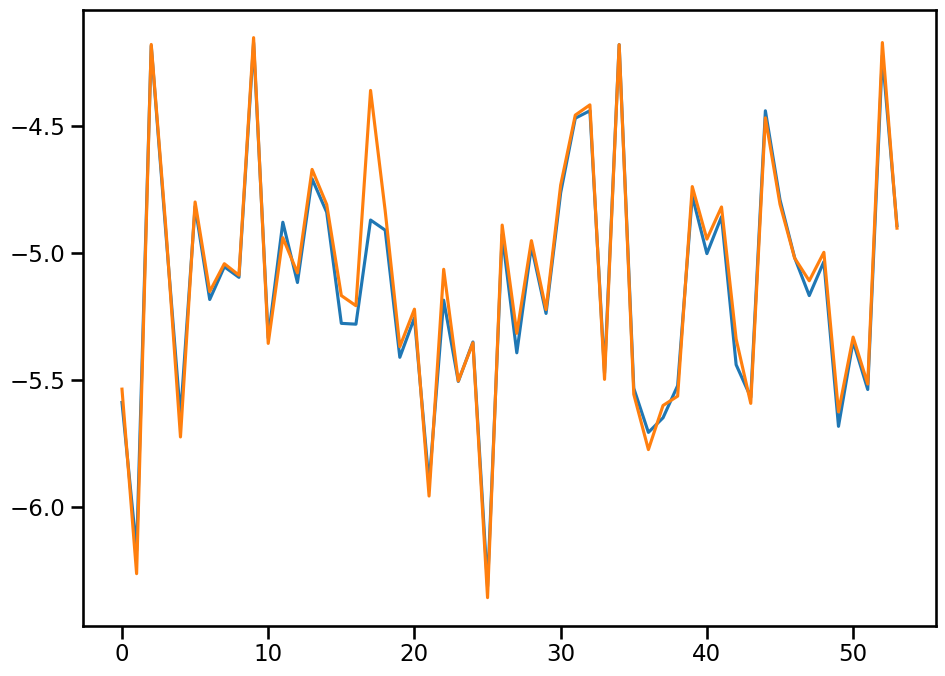

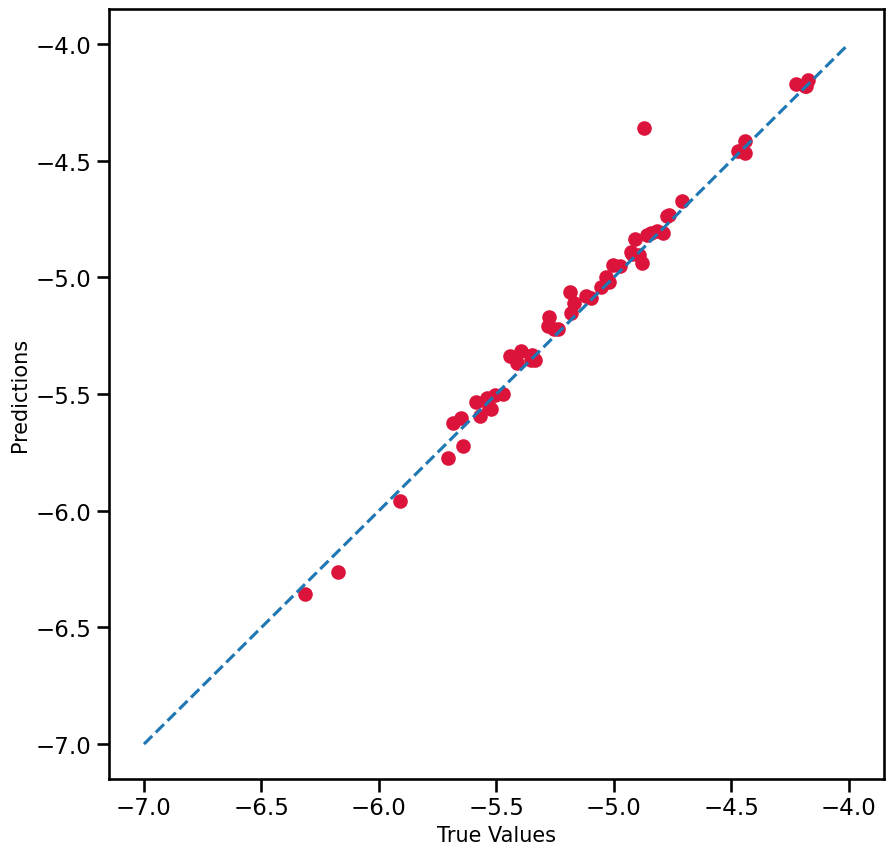

In [40]:
x_ax=range(len(Y_test))
plt.plot(x_ax,Y_test,label="original")
plt.plot(x_ax,pred_new_ar,label="predicted")
plt.show()

plt.figure(figsize=(10,10))
ax_x=range(-7,-3)
plt.plot(ax_x,ax_x,"--")
plt.scatter(Y_test, pred_new_ar, c='crimson')




plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)

plt.show()

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

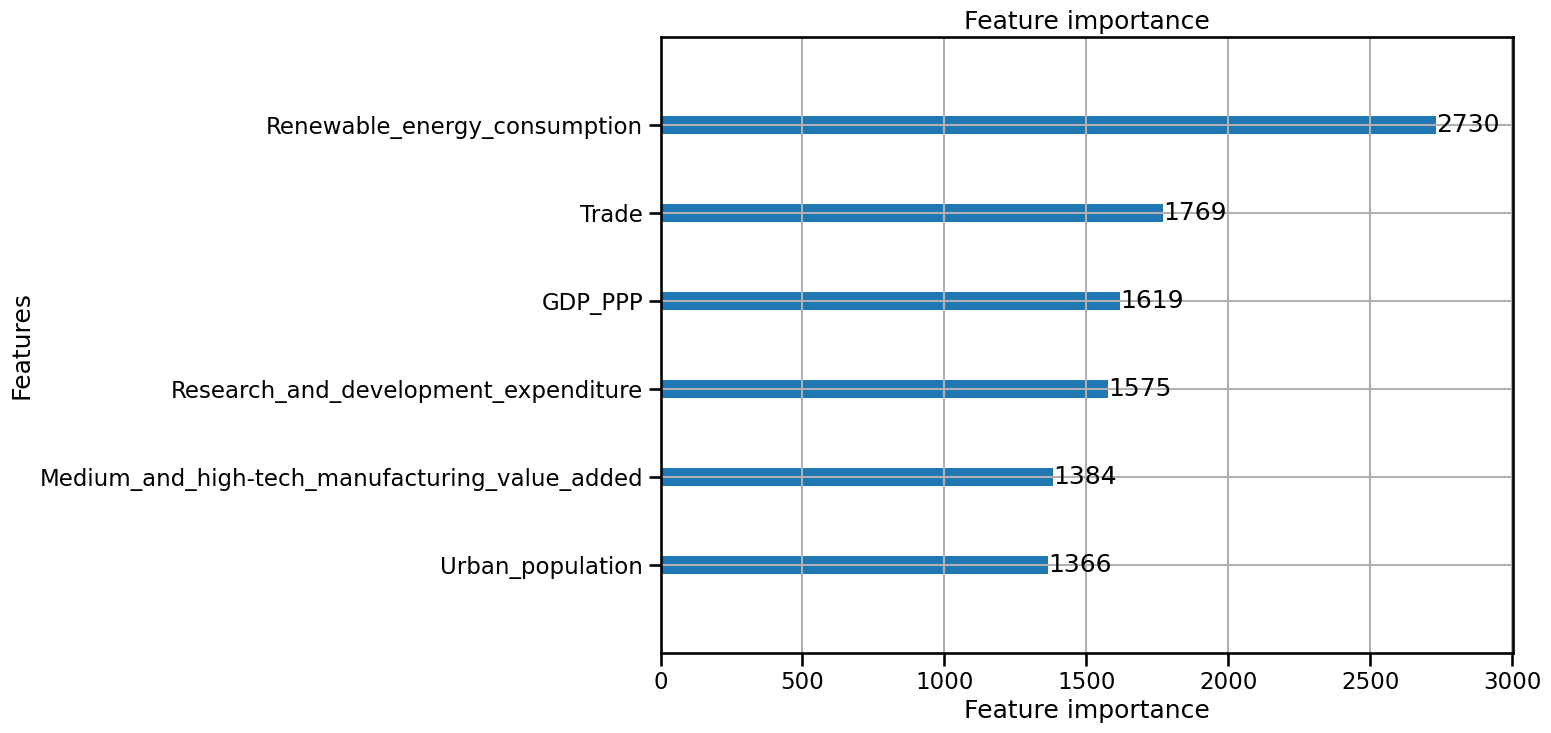

In [36]:
gpb.plot_importance(bst_ar)


In [37]:
gpb.plot_tree(bst_ar, figsize = (50,50), dpi = 600)

<AxesSubplot:>

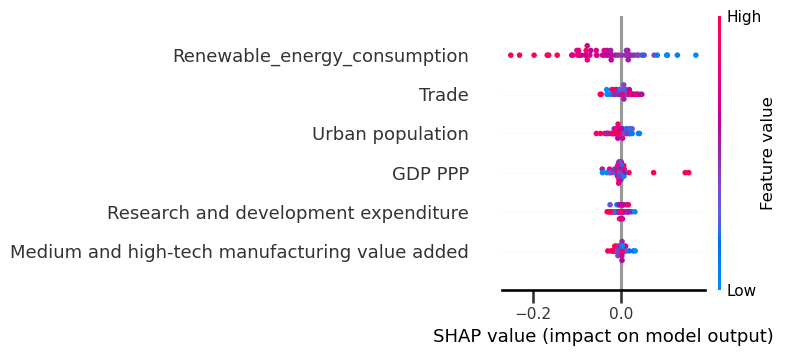

In [41]:
shap_values = shap.TreeExplainer(bst_ar).shap_values(X_test)
shap.summary_plot(shap_values, X_test)